## Calculating the SNR associated with an astrophysical signal model

In [40]:
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

from pycbc.types import FrequencySeries
from gwpy.timeseries import TimeSeries
import nds2
import matplotlib.pyplot as plt
import pycbc
import numpy as np
from fastgb import fastgb

import pycbc.detector.space
import pycbc.psd.analytical_space 


Import LISA psd from pycbc

/home/alice/miniforge3/envs/gwpy_env/lib/python3.12/site-packages/pycbc/psd/read.py:82: RuntimeWarning: divide by zero encountered in log
  vals = numpy.log(numpy.arange(kmin, length) * delta_f)


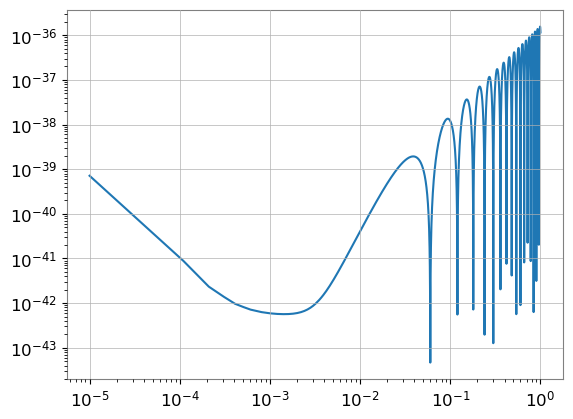

In [41]:
psd = pycbc.psd.analytical_space.analytical_psd_lisa_tdi_XYZ

fMin_psd = 1e-5
fMax_psd = 1
delta_f = 0.0001
fr = np.arange(fMin_psd, fMax_psd, delta_f)
flen = len(fr)
low_frequency_cutoff = fMin_psd

#print(psd(flen, delta_f, low_frequency_cutoff, tdi=1.5))

#Plot PSD
plt.loglog(fr,psd(flen, delta_f, low_frequency_cutoff, tdi=1.5))
plt.show()


Plot sensitivity curve

In [42]:
response = pycbc.psd.analytical_space.averaged_response_lisa_tdi

sensitivity =  psd(flen, delta_f, low_frequency_cutoff, tdi=1.5)/(response(fr, tdi = 2.0)) 
f_k = np.full(len(fr), 0.00258) 
gal_foreground = 9e-25*fr**(7/3) * np.exp(-0.138*fr-221*fr*np.sin(482*fr))*(1 + np.tanh(f_k-1680*fr))
#plt.loglog(fr, np.sqrt(sensitivity))
#plt.loglog(fr, 4* np.pi**2 /(3*3.24e-18) *fr**3 * sensitivity) #energy density sensitivity 
#plt.loglog(fr, response(fr,tdi=1.5))
#plt.loglog(fr, 4* np.pi**2 /(3*3.24e-18) *fr**3 * gal_foreground)
#plt.show()

## Define inner product functions to calculate SNR

In [43]:
def noise_weighted_inner_product(aa, bb, power_spectral_density, duration):
    """
    Calculate the noise weighted inner product between two arrays.

    Parameters
    ==========
    aa: array_like
        Array to be complex conjugated
    bb: array_like
        Array not to be complex conjugated
    power_spectral_density: array_like
        Power spectral density of the noise
    duration: float
        duration of the data

    Returns
    =======
    Noise-weighted inner product.
    """

    integrand = np.conj(aa) * bb / power_spectral_density
    return 4 / duration * integrand.sum()

def optimal_snr_squared(signal, power_spectral_density, duration):
    """
    Compute the square of the optimal matched filter SNR for the provided
    signal.


    Parameters
    ==========
    signal: array_like
        Array containing the signal
    power_spectral_density: array_like

    duration: float
        Time duration of the signal

    Returns
    =======
    float: The optimal matched filter signal to noise ratio squared

    """
    return noise_weighted_inner_product(signal, signal, power_spectral_density, duration)


def matched_filter_snr(signal, frequency_domain_strain, power_spectral_density, duration):
    """
    Calculate the _complex_ matched filter snr of a signal.
    This is <signal|frequency_domain_strain> / optimal_snr

    Parameters
    ==========
    signal: array_like
        Array containing the signal
    frequency_domain_strain: array_like

    power_spectral_density: array_like

    duration: float
        Time duration of the signal

    Returns
    =======
    float: The matched filter signal to noise ratio squared

    """
    rho_mf = noise_weighted_inner_product(
        aa=signal, bb=frequency_domain_strain,
        power_spectral_density=power_spectral_density, duration=duration)
    rho_mf /= optimal_snr_squared(
        signal=signal, power_spectral_density=power_spectral_density,
        duration=duration)**0.5
    return rho_mf



## LISA response
First define LISA position in the sky depending on time tm, return unit vectors $n_{rs}$

In [44]:
# Set constants: Speed of light, year in seconds, AU in seconds, armlength in seconds
c = 299792458.0
year = 31558149.763545603
AUs = 499.00478383615643
L = 2.5e9/c

tm = np.arange(0, year, 1000)

def LISAmotion(tm):
    # starting position offset
    lamb = 0.0
    kappa = 0.0

    N = len(tm)

    a = AUs
    e = L/(2.0*np.sqrt(3.0)*a) #eccentricity
    nn = np.array([1,2,3])

    Beta = (nn-1)*2.0*np.pi/3.0 + lamb # position of the spacecrafts
    alpha = 2.0*np.pi*tm/year + kappa  # LISA CoM position

    # x,y,z coordinates of 3 satellites in SSB coordinates
    x = np.zeros((3, N))
    y = np.zeros((3, N))
    z = np.zeros((3, N))
    for i in range(3):
        x[i, :] = a*np.cos(alpha) + a*e*(np.sin(alpha)*np.cos(alpha)*np.sin(Beta[i]) - (1.0 + (np.sin(alpha))**2)*np.cos(Beta[i]))
        y[i, :] = a*np.sin(alpha) + a*e*(np.sin(alpha)*np.cos(alpha)*np.cos(Beta[i]) - (1.0 + (np.cos(alpha))**2)*np.sin(Beta[i]))
        z[i, :] = -np.sqrt(3.0)*a*e*np.cos(alpha - Beta[i])
        
    ### Links
    n23 = np.array([x[1,:]-x[2,:], y[1,:]-y[2,:], z[1,:] - z[2,:]])/L
    n31 = np.array([x[2,:]-x[0,:], y[2,:]-y[0,:], z[2,:] - z[0,:]])/L
    n12 = np.array([x[0,:]-x[1,:], y[0,:]-y[1,:], z[0,:] - z[1,:]])/L

    ## Vector position of satellites
    r1 = np.array([x[0,:], y[0,:], z[0,:]])
    r2 = np.array([x[1,:], y[1,:], z[1,:]])
    r3 = np.array([x[2,:], y[2,:], z[2,:]])

    return ((n23, n31, n12), (r1, r2, r3))

In [45]:
t = 100 # time to calculate LISA position in s
n23, n31, n12 = (LISAmotion(np.array([t]))[0]) # unit vectors at time t 
#print(n23)
r1, r2, r3 = (LISAmotion(np.array([t]))[1]) # position vectors at time t

Response functions (eq. 34,35 from https://arxiv.org/abs/2108.01167)

$ F_{rs}^+ = \hat{n}^i_{rs} \hat{n}^j_{rs} [ \epsilon^+_{ij} cos(2\psi) + \epsilon^\times_{ij} sin(2\psi)]$


$ F_{rs}^\times = \hat{n}^i_{rs} \hat{n}^j_{rs} [- \epsilon^+_{ij} sin(2\psi) + \epsilon^\times_{ij} cos(2\psi)]$


$ \Upsilon_{rs} = Sinc\left[  \frac{\omega L}{2} (1 - \hat{k}.\hat{n}_{rs})\right] e^{-i  \frac{\omega L}{2} (1 - \hat{k}.\hat{n}_{rs})} + Sinc\left[  \frac{\omega L}{2} (1 - \hat{k}.\hat{n}_{sr})\right] e^{-i  \frac{\omega L}{2} (3 + \hat{k}.\hat{n}_{sr})}
$

In [46]:
def Fp_rs(psi, lam, bet, n):
    # psi = polarization angle, [0, pi] 
    # lam = ecliptic longitude, [0, 2pi]
    # bet = ecliptic latitude, [-pi/2, pi/2]
    # n = unit vector receiver-sender, n23, n31, n12 = LISAmotion(np.array[time])
    u = np.array([np.sin(lam), -np.cos(lam), 0.0])
    v = np.array([-np.sin(bet)*np.cos(lam), -np.sin(bet)*np.sin(lam), np.cos(bet)])
    
    nu = np.dot(u, n)
    nv = np.dot(v, n)
        
    plus = nu*nu - nv*nv
    cros = 2.*nu*nv
    
    Fp = np.cos(psi)*plus + np.sin(psi)*cros
    
    return (Fp)
    

def Fc_rs(psi, lam, bet, n):
    
    u = np.array([np.sin(lam), -np.cos(lam), 0.0])
    v = np.array([-np.sin(bet)*np.cos(lam), -np.sin(bet)*np.sin(lam), np.cos(bet)])
    
    nu = np.dot(u, n)
    nv = np.dot(v, n)
    
    plus = nu*nu - nv*nv
    cros = 2.*nu*nv
    
    Fc = -np.sin(psi)*plus + np.cos(psi)*cros
    
    return (Fc)

def Psi(lam, bet, n, f):
    # f = array of frequencies of GW
    ### direction of GW propagation
    k = -1.*np.array([np.cos(bet)*np.cos(lam), np.cos(bet)*np.sin(lam), np.sin(bet)])
    
    kn = np.dot(k, n)

    x = 2*np.pi*f*L
    
    Gam_rs = np.sinc( (1.-kn)*0.5*x/np.pi ) *np.exp(-0.5j*x*(1.-kn))
    Gam_sr = np.sinc( (1.+kn)*0.5*x/np.pi ) *np.exp(-0.5j*x*(1.+kn))
    
    Psi_rs = Gam_rs + Gam_sr*np.exp(-1.j*x*(1-kn))
    
    return (Psi_rs) # returns an array

Response for TDI 1.5 and TDI 2.0 (here for X channel) 

$ X^{GW}_{1.5} = (\omega L) sin(\omega L) e^{-i(|\vec{k}| (t - \hat{k}.\vec{R_1}) - \omega L)} [ A_+ [F^+_{13}\Upsilon_{13} - F^+_{12}\Upsilon_{12}] +
A_\times [F^\times_{13}\Upsilon_{13} - F^\times_{12}\Upsilon_{12}] ]$

$ X^{GW}_{2.0} = 2i sin(2 \omega L) e^{-2i \omega L} X^{GW}_{1.5} $

In [47]:
def tdiX_15(hplus, hcross, psi, lam, bet):
    # hplus,hcross: FrequencySeries
    f = hplus.sample_frequencies
    om = 2*np.pi*f
    x = om*L

    k = -1.*np.array([np.cos(bet)*np.cos(lam), np.cos(bet)*np.sin(lam), np.sin(bet)])
    kr = np.dot(k, r1)

    n13 = -n31

    Fp = Fp_rs(psi=psi, lam=lam, bet=bet, n=n13)*Psi(lam=lam, bet=bet, n=n13, f=f) - Fp_rs(psi=psi, lam=lam, bet=bet, n=n12)*Psi(lam=lam, bet=bet, n=n12, f=f)
    Fc = Fc_rs(psi=psi, lam=lam, bet=bet, n=n13)*Psi(lam=lam, bet=bet, n=n13, f=f) - Fc_rs(psi=psi, lam=lam, bet=bet, n=n12)*Psi(lam=lam, bet=bet, n=n12, f=f)
    X = x*np.sin(x)* np.exp(-1j*(om*(t - kr)-x))*(hplus*Fp + hcross*Fc)

    return X
# f = hp.sample_frequencies

Get Y and Z channels by permutation of indices

In [48]:
def tdiY_15(hplus, hcross, psi, lam, bet):
    f = hplus.sample_frequencies
    om = 2*np.pi*f
    x = om*L

    k = -1.*np.array([np.cos(bet)*np.cos(lam), np.cos(bet)*np.sin(lam), np.sin(bet)])
    kr = np.dot(k, r1)

    n21 = -n12

    Fp = Fp_rs(psi=psi, lam=lam, bet=bet, n=n21)*Psi(lam=lam, bet=bet, n=n21, f=f) - Fp_rs(psi=psi, lam=lam, bet=bet, n=n23)*Psi(lam=lam, bet=bet, n=n23, f=f)
    Fc = Fc_rs(psi=psi, lam=lam, bet=bet, n=n21)*Psi(lam=lam, bet=bet, n=n21, f=f) - Fc_rs(psi=psi, lam=lam, bet=bet, n=n23)*Psi(lam=lam, bet=bet, n=n23, f=f)
    Y = x*np.sin(x)* np.exp(-1j*(om*(t - kr)-x))*(hplus*Fp + hcross*Fc)

    return Y

def tdiZ_15(hplus, hcross, psi, lam, bet):
    # hplus,hcross: FrequencySeries
    f = hplus.sample_frequencies
    om = 2*np.pi*f
    x = om*L

    k = -1.*np.array([np.cos(bet)*np.cos(lam), np.cos(bet)*np.sin(lam), np.sin(bet)])
    kr = np.dot(k, r1)

    n32 = -n23

    Fp = Fp_rs(psi=psi, lam=lam, bet=bet, n=n32)*Psi(lam=lam, bet=bet, n=n32, f=f) - Fp_rs(psi=psi, lam=lam, bet=bet, n=n31)*Psi(lam=lam, bet=bet, n=n31, f=f)
    Fc = Fc_rs(psi=psi, lam=lam, bet=bet, n=n32)*Psi(lam=lam, bet=bet, n=n32, f=f) - Fc_rs(psi=psi, lam=lam, bet=bet, n=n31)*Psi(lam=lam, bet=bet, n=n31, f=f)
    Z = x*np.sin(x)* np.exp(-1j*(om*(t - kr)-x))*(hplus*Fp + hcross*Fc)

    return Z

Define $TDI_{2.0}$:

$X^{GW}_{2.0} = 2i sin(2 \omega L) e^{-2i \omega L} X^{GW}_{1.5}$

In [49]:
def tdiX_20(hplus, hcross, psi, lam, bet):
    f = hplus.sample_frequencies
    om = 2*np.pi*f

    return 2j*np.sin(2*om*L)*np.exp(-2j*om*L)*tdiX_15(hplus,hcross,psi,lam,bet)

def tdiY_20(hplus, hcross, psi, lam, bet):
    f = hplus.sample_frequencies
    om = 2*np.pi*f

    return 2j*np.sin(2*om*L)*np.exp(-2j*om*L)*tdiY_15(hplus,hcross,psi,lam,bet)

def tdiZ_20(hplus, hcross, psi, lam, bet):
    f = hplus.sample_frequencies
    om = 2*np.pi*f

    return 2j*np.sin(2*om*L)*np.exp(-2j*om*L)*tdiZ_15(hplus,hcross,psi,lam,bet)

## Generating a signal model

In order to calculate signal-to-noise ratio, we need a signal model against which to compare our data.
 For this we import :func:`pycbc.waveform.get_fd_waveform <pycbc.waveform.waveform.get_fd_waveform>` and generate a template as a `pycbc.types.FrequencySeries <pycbc.types.frequencyseries.FrequencySeries>`:

In [144]:
# Set parameters for waveform
fMin = 1e-3
fMax = 1
delta_f = 0.001
fr = np.arange(fMin, fMax, delta_f)
low_frequency_cutoff = fMin

# Time domain waveform
from pycbc.waveform import get_td_waveform
apx = 'IMRPhenomD'
#hp, hc = get_td_waveform(approximant=apx,
#                             mass1=1e5,
#                             mass2=1e5,
#                             delta_t=0.1,
#                             f_lower=0.001)

#plt.plot(hp.sample_times, hp, label=apx)

In [146]:
# Frequency domain waveform

apx = "TaylorF2" #waveform approximant
from pycbc.waveform import get_fd_waveform
hp_, hc_ = get_fd_waveform(
    #approximant="IMRPhenomD",
    approximant=apx,
    mass1=0.27,
    mass2=0.55,
    f_lower=fMin,
    delta_f=delta_f,
    f_final = fMax,
    distance = 0.005, # in Mpc
    inclination = np.deg2rad(38)
)
# default luminosity distance = 1Mpc

# clean data: replace Nans with zeros
def clean_fdata(h):
    # h: frequency series, plus or cross
    data = h.data
    real = np.nan_to_num(data.real, nan=0.0)
    imag = np.nan_to_num(data.imag, nan=0.0)
    clean_data = real + 1j*imag 

    return FrequencySeries(clean_data, delta_f=h.delta_f)

hp = clean_fdata(hp_)
hc = clean_fdata(hc_)

#plt.plot(hp.sample_frequencies, hp, label=apx)
#plt.xscale('log')


## SNR calculation

$ SNR^2_{optimal} = 4 Re[\int_0^{f_{max}} \frac{\~{h^*} \~{h}}{S_n} df] $ 

In [147]:
XX = tdiX_15(hp, hc, 0, 0 ,0)

print(psd(len(XX), delta_f, low_frequency_cutoff, tdi=1.5))
snr_x = optimal_snr_squared(XX, psd(len(XX), delta_f, low_frequency_cutoff, tdi=1.5), 1/delta_f)
print(np.sqrt(snr_x).real)

#plt.plot(hp.sample_frequencies, XX)
#plt.plot(hp.sample_frequencies, hp)
#plt.xscale('log')


[0.00000000e+00 5.89663812e-43 7.53904627e-43 ... 1.28652207e-36
 1.22078605e-36 1.15035044e-36]
nan


/home/alice/miniforge3/envs/gwpy_env/lib/python3.12/site-packages/pycbc/types/array.py:383: RuntimeWarning: invalid value encountered in divide
  return self._data / other


In [140]:
import random
#create random position on the sky of source and random polarization angle
lam_random = random.uniform(0, 2*np.pi)
bet_random = random.uniform(-np.pi/2, np.pi/2)
psi_random = random.uniform(0, np.pi)
print((lam_random, bet_random, psi_random  ))
#compute TDI for random sky position and polarization angle
XX = tdiX_15(hp, hc, psi_random, lam_random ,bet_random)

#snr calculation
snr_x = optimal_snr_squared(XX, psd(len(XX), delta_f, low_frequency_cutoff, tdi=1.5), 1/delta_f)
print(np.sqrt(snr_x).real)

#plotting TDI channels for random sky position and polarization angle
#plt.plot(hp.sample_frequencies,XX)
#plt.xscale('log')

(1.2562567982266721, 1.4897872284932032, 1.5640214581798972)
27095.215700477038


## Check PSD

In [233]:
# --- noise psd model for the data analysis ----
import scipy.constants as constants

def C_xx(omega, L):
    return 16 * (np.sin(omega * L) ** 2) * (np.sin(2 * omega * L) ** 2)
 
def C_xy(omega, L):
    return -16 * (np.sin(omega * L)) * (np.sin(2 * omega * L) ** 3)
 
# Transfer functions fot the AE channels
 
def TransferAE_acc(omega, L):
    return 4 * C_xx(omega, L) * (3 + 2 * np.cos(omega * L) + np.cos(2 * omega * L))
 
def TransferAE_OMS(omega, L):
    return 2 * C_xx(omega, L) * (2 + np.cos(omega * L))
 
def S_acc(f):
    A_acc = 3 * 1e-15
    f_acc = 4 * 1e-4
    S_acc = (
        A_acc**2
        * (1 / (2 * np.pi * f * constants.c)**2)
        * (1 + (f_acc / f) ** 2)
        * (1 + (f / (8 * 1e-3)) ** 4)
    )
    return S_acc
 
def S_OMS(f):
    A_oms = 15 * 1e-12
    f_oms = 2 * 1e-3
    S_oms = A_oms**2 * ((2 * np.pi * f) / (constants.c)) ** 2 * (1 + (f_oms / f) ** 4)
    return S_oms
 
 
def S_acc_AE(f):
    return TransferAE_acc(2 * np.pi * f, L) * S_acc(f)
 
 
def S_OMS_AE(f):
    return TransferAE_OMS(2 * np.pi * f, L) * S_OMS(f)
 
 
def noise_psd_chunk( f):
    """
    chunk dependent noise psd
    """
    return S_acc_AE(f) + S_OMS_AE(f)

from pycbc.psd.analytical_space import analytical_psd_lisa_tdi_AE as psd_AE
fMin = 0.006617960426179604
fMax = 0.006622019279553526
delta_f = 3.1709791983764586e-08
fr = np.arange(fMin, fMax, delta_f)
low_frequency_cutoff = fMin

print(noise_psd_chunk(fr))
#print(psd_AE(len(fr), delta_f, fMin, tdi=1.5))
#snr_AE = optimal_snr_squared(XX, noise_psd_chunk(fr), 1/delta_f)
#print(np.sqrt(snr_AE).real)


[2.08396771e-41 2.08402083e-41 2.08407396e-41 2.08412709e-41
 2.08418022e-41 2.08423335e-41 2.08428648e-41 2.08433961e-41
 2.08439275e-41 2.08444588e-41 2.08449902e-41 2.08455216e-41
 2.08460530e-41 2.08465844e-41 2.08471158e-41 2.08476472e-41
 2.08481786e-41 2.08487100e-41 2.08492415e-41 2.08497730e-41
 2.08503044e-41 2.08508359e-41 2.08513674e-41 2.08518989e-41
 2.08524304e-41 2.08529620e-41 2.08534935e-41 2.08540250e-41
 2.08545566e-41 2.08550882e-41 2.08556198e-41 2.08561513e-41
 2.08566829e-41 2.08572146e-41 2.08577462e-41 2.08582778e-41
 2.08588095e-41 2.08593411e-41 2.08598728e-41 2.08604045e-41
 2.08609362e-41 2.08614679e-41 2.08619996e-41 2.08625313e-41
 2.08630630e-41 2.08635948e-41 2.08641266e-41 2.08646583e-41
 2.08651901e-41 2.08657219e-41 2.08662537e-41 2.08667855e-41
 2.08673173e-41 2.08678492e-41 2.08683810e-41 2.08689129e-41
 2.08694447e-41 2.08699766e-41 2.08705085e-41 2.08710404e-41
 2.08715723e-41 2.08721042e-41 2.08726362e-41 2.08731681e-41
 2.08737001e-41 2.087423

## Check SNR with FastGB

In [230]:
from lisaorbits import EqualArmlengthOrbits
pGB = np.array([0.00662, # f0 Hz
                0, # fdot "Hz^2
				6.4e-23, # ampl strain
				np.deg2rad(23.3952),  # eclipticlatitude radian b
               	np.deg2rad(206.9246),   # eclipticLongitude radian l
	        	0, # polarization radian
                np.deg2rad(38),  # inclination radian
				0, # initial phase radian
      	       ])
T_obs = 365*24*3600
N = 128
 # delta_t = sampling time in td
fgb = fastgb.FastGB(delta_t=5, T=T_obs, N=N, orbits=EqualArmlengthOrbits())
X, Y, Z, kmin = fgb.get_fd_tdixyz(pGB.reshape(1,-1))

df = 1/T_obs
f_max = df*(N + kmin[0])
f_min = df*kmin[0]
f_arr =(np.arange(N) + kmin[0])*df
print(f_min, f_max, df)
#plt.plot(f_arr, X[0])
# f_min too big to be low_freq_cutoff -> psd contains a lot of 0s

delta_ff = 0.01
#print(psd(N, df, f_min, tdi =1.5))
snr = optimal_snr_squared(X[0], noise_psd_chunk(f_arr), T_obs)
snr_fast = optimal_snr_squared(X[0], psd(N, delta_ff, f_min, tdi =1.5), 1/delta_ff)
print(np.sqrt(snr).real)
#print(np.sqrt(snr_fast).real)


0.006617960426179604 0.006622019279553526 3.1709791983764586e-08
31.660183346426127


/home/alice/miniforge3/envs/gwpy_env/lib/python3.12/site-packages/pycbc/psd/read.py:82: RuntimeWarning: divide by zero encountered in log
  vals = numpy.log(numpy.arange(kmin, length) * delta_f)
